In [1]:
import numpy as np
from scipy.special import softmax

RNG = np.random.default_rng(seed=0)

n, r, p = 200, 10, 100
x = RNG.multivariate_normal(mean=np.zeros(p), cov=np.eye(p), size=n)

k = 5
beta_prime = RNG.multivariate_normal(mean=np.zeros(r), cov=np.eye(r), size=k)
relevant = RNG.choice(p, r, replace=False)
beta = np.zeros(shape=(k,p))
beta[:, relevant] = beta_prime
probs = softmax(x.dot(beta.T), axis=1)
y = np.array([RNG.multinomial(1, probs[i]) for i in range(n)])
_, y = np.nonzero(y)
y

array([1, 2, 2, 3, 1, 3, 1, 2, 0, 0, 1, 2, 1, 2, 0, 2, 0, 1, 2, 1, 4, 2,
       4, 0, 0, 4, 2, 1, 1, 0, 2, 2, 4, 1, 3, 3, 2, 2, 2, 4, 2, 4, 0, 4,
       4, 2, 2, 0, 0, 0, 4, 1, 1, 0, 4, 0, 0, 4, 1, 4, 2, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 4, 0, 0, 1, 3, 3, 2, 3, 2, 1, 0, 4, 0, 3, 0, 1, 2, 3,
       4, 3, 3, 1, 0, 1, 0, 0, 2, 2, 1, 2, 4, 1, 0, 2, 0, 1, 3, 1, 4, 4,
       0, 0, 3, 4, 2, 1, 0, 2, 1, 0, 1, 4, 1, 1, 4, 3, 4, 2, 1, 2, 1, 4,
       0, 3, 2, 1, 0, 4, 0, 1, 2, 0, 1, 1, 4, 0, 0, 1, 0, 4, 4, 4, 4, 0,
       0, 4, 4, 2, 1, 0, 2, 3, 4, 0, 0, 1, 0, 0, 4, 1, 1, 4, 0, 2, 2, 4,
       2, 0, 2, 0, 1, 0, 2, 3, 1, 1, 4, 3, 1, 2, 1, 4, 0, 4, 1, 0, 1, 3,
       1, 4])

In [2]:
relevant

array([97, 70, 47,  8,  4, 11, 39, 46, 59, 94])

In [4]:
# from collections import defaultdict
# from scipy.stats import entropy 

# def incremental_entropy(h_old, n, c_old, c_new):
#     delta = c_new - c_old
#     if n == 0 or n == -delta: # old or new histogram empty
#         return 0.0
#     else:
#         new_term = c_new*np.log(c_new) if c_new > 0 else 0
#         old_term = c_old*np.log(c_old) if c_old > 0 else 0
#         return np.log(n+delta)-(new_term + n*(np.log(n)-h_old) - old_term)/(n+delta)

# class Binning2:

#     @staticmethod
#     def trivial(x, y):
#         n, _ = x.shape
#         k = len(np.unique(y))
#         # print('k', k)
#         bins = np.zeros(n, dtype=int)
#         max_bin = 0
#         counts =  defaultdict(int) # np.zeros(n, dtype=int)
#         counts[0] = n
#         y_counts = defaultdict(lambda : np.zeros(k, int)) # np.zeros(shape=(n, k), dtype=int)
#         _, y_counts[0] = np.unique(y, return_counts=True)
#         cond_entr = defaultdict(float) # np.zeros(n)
#         cond_entr[0] = entropy(y_counts[0], base=np.e)
#         return Binning2(x, y, bins, max_bin, counts, y_counts, cond_entr, cond_entr[0], 1)
    
#     @staticmethod
#     def from_assignment(x, y, bins):
#         binning = Binning2.trivial(x, y)
#         for i, dest in enumerate(bins):
#             binning.move(i, dest)
#         return binning

#     def __init__(self, x, y, bins, max_bin, counts, y_counts, cond_entr, mean_cond_entr, non_empty_bin_count):
#         n, _ = x.shape
#         self.n = n
#         self.x = x
#         self.y = y
#         self.bins = bins
#         self.max_bin = max_bin
#         self.counts = counts
#         self.y_counts = y_counts
#         self.cond_entr = cond_entr
#         self.mean_cond_entr = mean_cond_entr
#         self.non_empty_bin_count = non_empty_bin_count

#     def move(self, i, dest):
#         orig = self.bins[i]
#         if orig == dest: 
#             return
        
#         self.bins[i] = dest
#         c = self.y[i]
#         self.mean_cond_entr = self.mean_cond_entr - self.counts[orig]*self.cond_entr[orig]/self.n - self.counts[dest]*self.cond_entr[dest]/self.n
#         self.counts[orig] -= 1
#         self.counts[dest] += 1
#         self.non_empty_bin_count = self.non_empty_bin_count + (self.counts[dest] == 1) - (self.counts[orig] == 0)
#         self.y_counts[orig][c] -= 1
#         self.y_counts[dest][c] += 1
#         self.cond_entr[orig] = incremental_entropy(self.cond_entr[orig], self.counts[orig]+1, self.y_counts[orig][c]+1, self.y_counts[orig][c])
#         self.cond_entr[dest] = incremental_entropy(self.cond_entr[dest], self.counts[dest]-1, self.y_counts[dest][c]-1, self.y_counts[dest][c])
#         self.mean_cond_entr = self.mean_cond_entr + self.counts[orig]*self.cond_entr[orig]/self.n + self.counts[dest]*self.cond_entr[dest]/self.n

#     def apply_cut_off(self, l, order):
#         # TODO: remove code duplication
#         split_off_bins = {}

#         for i in range(l+1):
#             j = order[i]
#             b = self.bins[j]
#             if b not in split_off_bins:
#                 self.max_bin += 1
#                 split_off_bins[b] = self.max_bin
#             _b = split_off_bins[b]
#             self.move(j, _b)

#     def best_cut_off(self, order, objective, candidate_mask):
#         _max_bin = self.max_bin
#         split_off_bins = {}
#         origins = np.zeros(self.n, dtype=int)

#         obj_star = float('inf')
#         i_star = -1
#         # forward
#         for i in range(self.n):
#             j = order[i]
#             b = self.bins[j]
#             if b not in split_off_bins:
#                 self.max_bin += 1
#                 split_off_bins[b] = self.max_bin
#             _b = split_off_bins[b]
#             origins[i] = b
#             self.move(j, _b)
#             if candidate_mask[i]:
#                 obj_value = objective(self)
#                 if obj_value < obj_star:
#                     i_star, obj_star = i, obj_value
        
#         # rewind
#         for i in range(self.n-1, -1, -1):
#             j = order[i]
#             self.move(j, origins[i])
#         self.max_bin = _max_bin

#         return i_star, obj_star
#         # return i_star, mean_cond_entr_star

In [36]:
# from scipy.stats import chi2
# from math import isclose

# def cond_entr_obj(binning):
#     return binning.mean_cond_entr


# class VariableSelection:

#     def __init__(self, delta=0.05, objective='cond_entr', multiple_cuts_per_var=True, verbose=False):
#         self.delta = delta
#         self.objective = objective
#         self.multiple_cuts_per_var = multiple_cuts_per_var
#         self.verbose = verbose

#     def p_value(self, binning):
#         scaled_mi_diff = 2*self.n_*(self.cond_entr_-binning.mean_cond_entr)
#         df = (self.k_-1)*(binning.non_empty_bin_count-self.non_empty_bin_count_)
#         return 1 - chi2.cdf(scaled_mi_diff, df)
    
#     @staticmethod
#     def cond_entr(binning):
#         return binning.mean_cond_entr

#     def fit(self, x, y):
#         obj_func = getattr(self, self.objective)
#         binning = Binning2.trivial(x, y)
#         orders = np.argsort(x, axis=0)

#         self.n_, self.p_ = x.shape
#         self.k_ = len(np.unique(y))
#         num_cand = int(self.n_**0.5)
#         cand_indx = int((self.n_/self.n_**0.5) / 2) + np.linspace(0, self.n_, num_cand, endpoint=False).astype(int)
#         cand_mask = np.zeros(self.n_, bool)
#         cand_mask[cand_indx] = True

#         self.non_empty_bin_count_ = binning.non_empty_bin_count
#         self.cond_entr_ = binning.mean_cond_entr
#         self.num_cuts_selected_ = np.zeros(self.p_, int)
#         t = 0

#         while True:
#             j_star, i_star, obj_star = -1, -1, float('inf')
#             for j in range(self.p_):
#                 if self.num_cuts_selected_[j]>0 and not self.multiple_cuts_per_var:
#                     continue
#                 i_j_star, obj_j_star = binning.best_cut_off(orders[:, j], obj_func, cand_mask)
#                 if obj_j_star < obj_star:
#                     j_star, i_star, obj_star = j, i_j_star, obj_j_star
            
#             binning.apply_cut_off(i_star, orders[:, j_star])
#             correction = (num_cand*self.p_-t) if self.multiple_cuts_per_var else (num_cand*(self.p_-t))
#             if self.p_value(binning) <= self.delta / correction:
#                 self.num_cuts_selected_[j_star] += 1
#                 self.cond_entr_ = binning.mean_cond_entr
#                 self.non_empty_bin_count_ = binning.non_empty_bin_count
#                 if self.verbose: print('.', end='')
#             else:
#                 break
#             t += 1
        
#         self.selected_ = np.flatnonzero(self.num_cuts_selected_)
#         self.num_cuts_selected_ = self.num_cuts_selected_[self.selected_]
#         return self

#     def transform(self, x):
#         return x[:, self.selected_]
    
#     def fit_transform(self, x, y):
#         return self.fit(x, y).transform(x)



In [5]:
from select_mi import VariableSelection

var_selection = VariableSelection(0.05, gamma=0.5, objective='p_value', verbose=True)
var_selection.fit(x, y)

...

In [6]:
var_selection.selected_

array([46, 70, 94])

In [7]:
var_selection.num_cuts_selected_

array([1, 1, 1])

In [8]:
np.intersect1d(relevant, var_selection.selected_)

array([46, 70, 94])

In [9]:
import numpy as np
from scipy.special import softmax
from sklearn.base import clone

class Problem:

    @staticmethod
    def randomSparseProblem(p, r, k, random_state=None):
        RNG = np.random.default_rng(seed=random_state)
        beta_prime = RNG.multivariate_normal(mean=np.zeros(r), cov=np.eye(r), size=k)
        relevant = RNG.choice(p, r, replace=False)
        beta = np.zeros(shape=(k,p))
        beta[:, relevant] = beta_prime
        return Problem(beta, relevant)

    def __init__(self, beta, relevant):
        self.beta = beta
        self.relevant = relevant
        self.k, self.p = self.beta.shape

    def rvs(self, n, random_state=None):
        RNG = np.random.default_rng(seed=random_state)
        x = RNG.multivariate_normal(mean=np.zeros(self.p), cov=np.eye(self.p), size=n)
        probs = softmax(x.dot(self.beta.T), axis=1)
        y = np.array([RNG.multinomial(1, probs[i]) for i in range(n)])
        _, y = np.nonzero(y)
        return x, y

In [13]:
class PrecisionRecallExperiment:

    def __init__(self, problem, reps, ns, methods, names):
        self.problem = problem
        self.reps = reps
        self.ns = ns
        self.methods = methods
        self.names = names

    def run(self):
        self.prec_ = np.zeros(shape=(len(self.methods), self.reps, len(self.ns)))
        self.rec_ = np.zeros(shape=(len(self.methods), self.reps, len(self.ns)))
        self.num_selected_ = np.zeros(shape=(len(self.methods), self.reps, len(self.ns)))
        self.mean_num_cuts_ = np.zeros(shape=(len(self.methods), self.reps, len(self.ns)))
        self.max_num_cuts_ = np.zeros(shape=(len(self.methods), self.reps, len(self.ns)))

        for j, n in enumerate(self.ns):
            print('n: ', n)
            for rep in range(self.reps):
                x, y = self.problem.rvs(n)
                for i, method in enumerate(self.methods):
                    selection = clone(method, safe=False)
                    selection.fit(x, y) 
                    intersection = np.intersect1d(selection.selected_, self.problem.relevant)
                    precision = len(intersection)/len(selection.selected_) if len(selection.selected_)>0 else 1.0
                    recall = len(intersection)/len(self.problem.relevant)
                    self.prec_[i, rep, j] = precision
                    self.rec_[i, rep, j] = recall
                    self.num_selected_[i, rep, j] = len(selection.selected_)
                    self.mean_num_cuts_[i, rep, j] = selection.num_cuts_selected_.mean() if len(selection.selected_)>0 else 0.0
                    self.max_num_cuts_[i, rep, j] = selection.num_cuts_selected_.max() if len(selection.selected_)>0 else 0.0
                    print('|', end='')
            print()

k = 5
r, p = 10, 50
problem = Problem.randomSparseProblem(p, r, k, random_state=0)

reps = 10
alpha = 0.16
gamma = 0.4
ns = np.array([50, 100, 200, 400, 800])
names = ['multiple MI', 
         'single MI', 
         'multiple p-val', 
         'single p-val']
methods = [VariableSelection(alpha, gamma=gamma, verbose=True), 
           VariableSelection(alpha, gamma=gamma, multiple_cuts_per_var=False, verbose=True),
           VariableSelection(alpha, gamma=gamma, objective='p_value', verbose=True),
           VariableSelection(alpha, gamma=gamma, objective='p_value', multiple_cuts_per_var=False, verbose=True)]

precision_recall_exp = PrecisionRecallExperiment(problem, reps, ns, methods, names)
precision_recall_exp.run()

n:  50
.|.|.|.|.|.|.|.|||||.|.|.|.|||||.|.|.|.|||||.|.|.|.|.|.|.|.|.|.|.|.|
n:  100
..|..|..|..|..|..|..|..|.|.|.|.|..|..|..|..|..|..|..|..|..|..|..|..|..|..|..|..|...|...|...|...|..|..|..|..|..|..|..|..|
n:  200
....|....|....|....|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|....|....|....|....|....|....|....|....|..|...|..|...|
n:  400
.....|.....|.....|.....|.....|.....|.....|.....|.....|.....|.....|.....|.....|.....|.....|.....|.....|.....|.....|.....|....|....|....|....|.....|.....|.....|.....|....|.....|.....|.....|.....|.....|.....|.....|....|....|....|....|
n:  800
......|......|......|......|......|......|......|......|......|......|......|......|.....|.....|.......|......|......|......|.......|......|......|......|.......|......|......|......|.......|......|......|......|......|......|......|......|......|.....|......|......|......|......|


In [73]:
from matplotlib import pyplot as plt

def plot_prec_rec_results(experiment):
    _, axs = plt.subplots(1, 4, figsize=(16, 4), tight_layout=True, sharex=True)
    for i in range(len(methods)):
        axs[0].errorbar(ns, experiment.rec_[i, :, :].mean(axis=0), 1.96*experiment.rec_[i, :, :].std(axis=0)/ns**0.5, label=names[i])
        axs[1].errorbar(ns, experiment.prec_[i, :, :].mean(axis=0), 1.96*experiment.prec_[i, :, :].std(axis=0)/ns**0.5, label=names[i])
        axs[2].errorbar(ns, experiment.num_selected_[i, :, :].mean(axis=0), 1.96*experiment.num_selected_[i, :, :].std(axis=0)/ns**0.5, label=names[i])
        axs[3].errorbar(ns, experiment.max_num_cuts_[i, :, :].mean(axis=0), 1.96*experiment.max_num_cuts_[i, :, :].std(axis=0)/ns**0.5, label=names[i])
    for i in range(4):
        axs[i].set_xlabel('$n$')
    axs[0].set_title('recall')
    axs[1].set_title('precision')
    axs[2].set_title('vars selected')
    axs[3].set_title('max cuts per var')
    axs[0].legend()


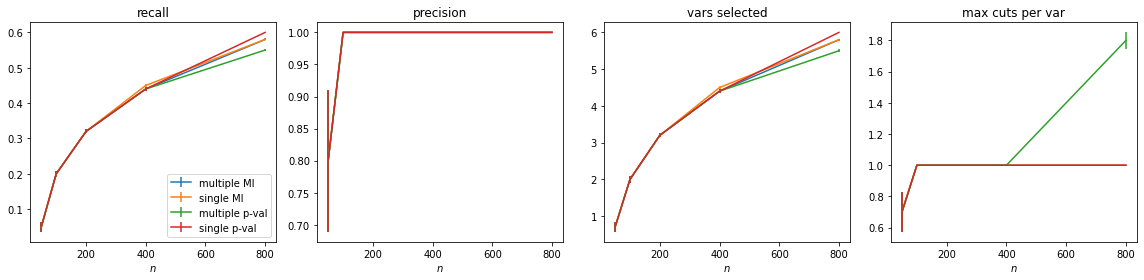

In [74]:

plot_prec_rec_results(precision_recall_exp)
plt.show()

In [63]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

k = 5
knn = KNeighborsClassifier(k)
knn_w_selection = make_pipeline(VariableSelection(delta=0.16, verbose=True), KNeighborsClassifier(k))

In [64]:
from sklearn.datasets import load_digits

digits = load_digits()
cv_digits_knn = cross_validate(knn, digits.data, digits.target)
cv_digits_knn

{'fit_time': array([0.0009439 , 0.00066781, 0.00058532, 0.00056338, 0.00056124]),
 'score_time': array([0.01819229, 0.01580811, 0.01433587, 0.01466084, 0.01380205]),
 'test_score': array([0.94722222, 0.95555556, 0.96657382, 0.98050139, 0.9637883 ])}

In [65]:
cv_digits_knn['test_score'].mean()

0.9627282575054161

In [66]:
cv_digits_knn_w_selection = cross_validate(knn_w_selection, digits.data, digits.target)
cv_digits_knn_w_selection

...............................

{'fit_time': array([29.69034982, 29.99945188, 29.69655609, 35.78906989, 34.69340801]),
 'score_time': array([0.00940895, 0.00954509, 0.0116961 , 0.01235294, 0.01136804]),
 'test_score': array([0.7       , 0.74722222, 0.75766017, 0.8356546 , 0.75208914])}

In [67]:
cv_digits_knn_w_selection['test_score'].mean()

0.7585252243887342

In [62]:
from sklearn.datasets import fetch_covtype

covtype = fetch_covtype()
cv_covtype_knn = cross_validate(knn, covtype.data[:20000], covtype.target[:20000])
cv_covtype_knn

{'fit_time': array([0.00741768, 0.00290895, 0.00300384, 0.00258517, 0.00240421]),
 'score_time': array([1.34362721, 1.45691228, 1.27403617, 1.23489094, 1.31987095]),
 'test_score': array([0.63925, 0.62925, 0.65025, 0.741  , 0.77775])}